In [1]:
import gpytorch
import torch

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

PI = torch.tensor(3.14159265359)

## Bayesian Optimisation with Gradients

Find $x^\ast$ such that 
$$
    x^\ast = \arg\min_{0\le x\le 1} f(x)
$$
where $f(x) = \sin(3\pi x) + x\cos(10\pi x)$, using known derivatives of $f$.

In [2]:
# def f(x): return (6*x-2)**2*torch.sin(12*x-4)

# def df(x): return 12*(6*x-2)*(torch.sin(12*x-4) + (6*x-2)*torch.cos(12*x-4))

In [3]:
def f(x): return torch.sin(3*PI*x) + x*torch.cos(10*PI*x)

def df(x): return -10*PI*x*torch.sin(10*PI*x) + 3*PI*torch.cos(3*PI*x) + torch.cos(10*PI*x)

Text(0, 0.5, 'df/dx')

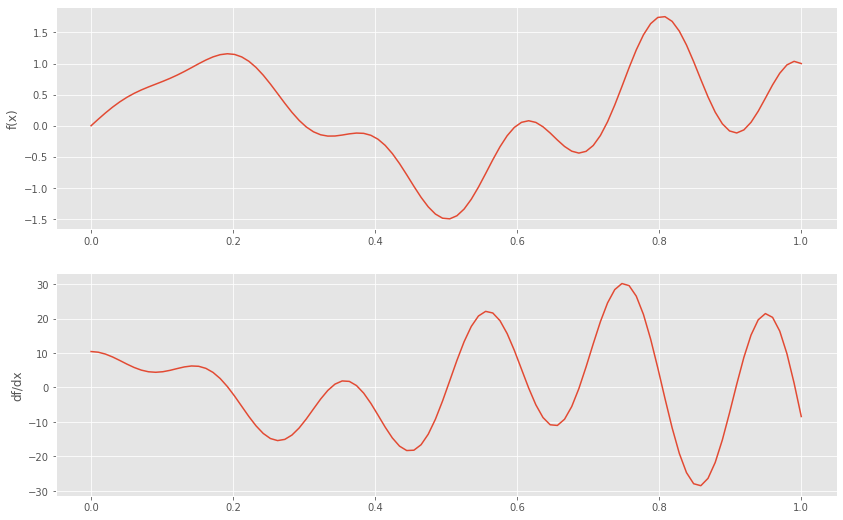

In [4]:
x_eval = torch.linspace(0,1,100)

_,axs=plt.subplots(2,1,figsize=(14,9))
axs[0].plot(x_eval, f(x_eval))
axs[0].set_ylabel('f(x)')
axs[1].plot(x_eval, df(x_eval))
axs[1].set_ylabel('df/dx')

### Build a GP model with gradients

`gpytorch` does this by building a multitask GP with automatic differentiation of the covariance functions, so the outputs are $f$ and $df/dx$. Below is a model class with RBF covariance and constant mean (scale kernel adds outer variance term for rbf kernel).

In [5]:
class ExactGPModelWithGrad(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelWithGrad, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(arg_num_dims=1)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

There's no built in optimiser so have to use `pytorch`'s ones to maximise marginal log likelihood. LBFGS doesn't seem to work stably with `gpytorch` and they generally recommend Adam. Since we want to fix the likelhiood terms, they are just omitted in the list of parameters to be optimised (l.9 in the cell below).

In [6]:
def optimise(model, method='adam', max_iter=None):
    if method is 'lbfgs': NotImplemented # lbfgs doesn't work well with gpytorch
    if method is 'adam': optimise_adam(model) if max_iter is None else optimise_adam(model, max_iter)
    
def optimise_adam(model, max_iter=50, fix_likelihood=True):
    model.train() # set model to train (gpytorch state)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    opt = torch.optim.Adam([ # use Adam optimiser (recommended by gpytorch) on parameters (ignore likelihood for bayesopt)
        {'params': [v for k,v in model.named_parameters() if 'likelihood' not in k] if fix_likelihood else model.parameters()}
    ], lr=0.1)
    for _ in range(max_iter): # no convergence criteria implemented but 1000 generally more than enough
        output = model(model.train_inputs[0]) # predicted f*
        loss   = -mll(output, model.train_targets) # MLE(f*, y)
        opt.zero_grad() # reset optimiser for this step
        loss.backward() # calculate gradients of MLE
        opt.step()      # iterate optimiser

In [7]:
def plot_gp(*args):
    ''' plotting utility for 2 task gp '''
    x_eval, model = (torch.linspace(0,1,100), args[0]) if len(args) < 2 else args
    
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(True):
        #f = model.likelihood(
        f = model(x_eval.unsqueeze(-1))#)
        mean = f.mean
        lci, uci = f.confidence_region()
        
        for i in range(2):
            plt.subplot(2,1,i+1)
            plt.plot(x_eval, mean[:,i].numpy(), 'b-')
            plt.fill_between(x_eval, lci[:,i].numpy(), uci[:,i].numpy(), alpha=0.1, color='b')
            plt.plot(model.train_inputs[0], model.train_targets[:,i], 'k.')

Take some observations of $f$ and $df/dx$ without noise.

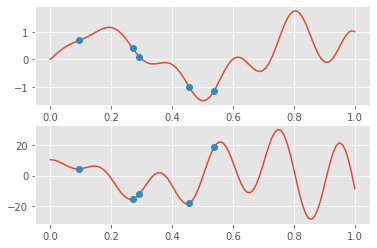

In [8]:
x_init = torch.rand(5).unsqueeze(-1)
y_init = torch.stack([f(x_init), df(x_init)],-1).squeeze(1)

_,axs=plt.subplots(2,1)
axs[0].plot(x_eval, f(x_eval))
axs[0].plot(x_init, y_init[:,0],'o')
axs[1].plot(x_eval, df(x_eval))
axs[1].plot(x_init, y_init[:,1],'o')

We fit a GP -- fix the likelihood noise to something small. Note by default he Gaussian Likelihood noise constraint is $>1\times10^{-4}$.

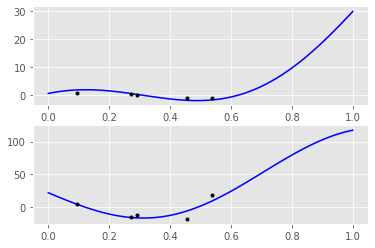

In [9]:
jit = 1e-5
model = ExactGPModelWithGrad(
    x_init, y_init, 
    gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.),
                                                     num_tasks=2)
)
# Set noise terms (these are then not trainable parameters in optimise())
model.likelihood.noise = torch.tensor(jit).sqrt()
model.likelihood.noise_covar.noise = jit*torch.ones(2)

plot_gp(model)

In [10]:
optimise(model, method='adam', max_iter=1000)

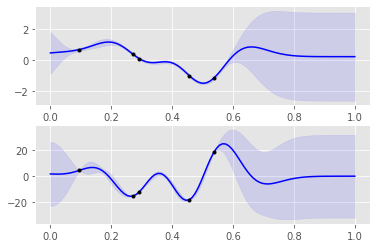

In [11]:
plot_gp(model)

### Expected Improvement
We build the acquisition function here. This is just the standard expected improvement on the prediction of $f$ only (`y[:,0]`)

In [12]:
def acq(fo, model, x_eval=None):
    model.eval()
    if x_eval is None: x_eval = torch.linspace(0,1,100).unsqueeze(-1)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(True):
        f_ = model(x_eval)
        mu, sig = f_.mean[:,0], f_.variance[:,0]#covariance_matrix

    _cdf = 0.5*(1+torch.erf((fo-mu)/(torch.sqrt(sig*2.))))
    _pdf = torch.exp(-(fo-mu)**2/(2*sig))/torch.sqrt(sig*2*3.141593)
    return (fo-mu)*_cdf + sig*_pdf

In [13]:
with torch.no_grad():
    u = acq(y_init[:,0].min(), model)
x_eval[u.argmax()] # the value of x with maxmium expected improevement

tensor(0.5051)

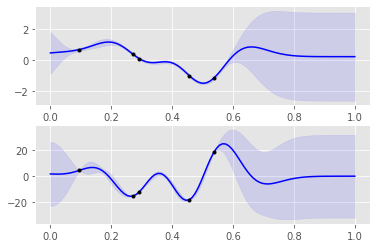

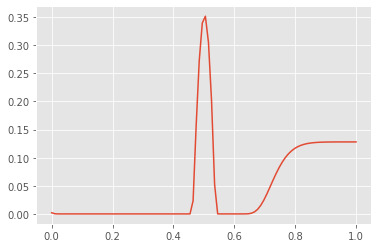

In [14]:
with torch.no_grad():
    plt.figure()
    plot_gp(model)
    plt.figure()
    plt.plot(torch.linspace(0,1,100),u)

### Bayesopt loop from scratch

Building on the above methods, below is a full optimisation routine. We start with 1 observation of $f$ and $df/dx$ and go from there:

In [15]:
x_init = torch.rand(1,).unsqueeze(-1)
y_init = torch.stack([f(x_init),df(x_init)],-1).squeeze(1)

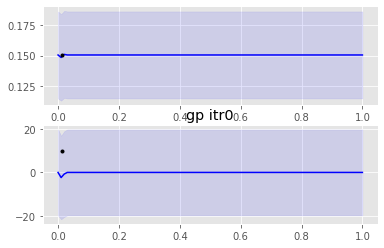

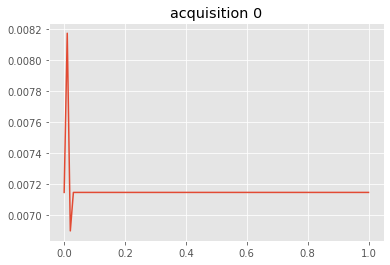

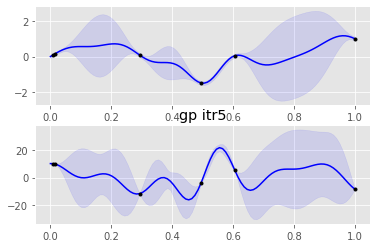

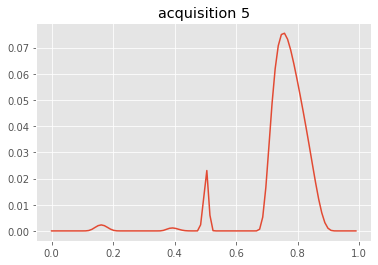

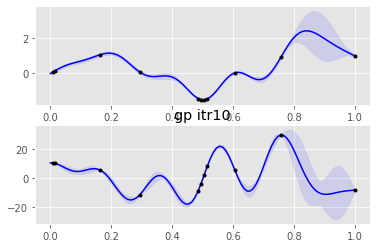

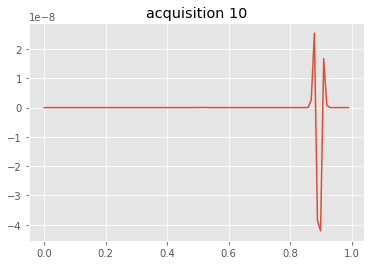

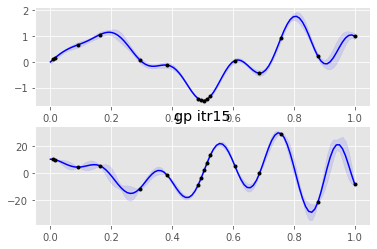

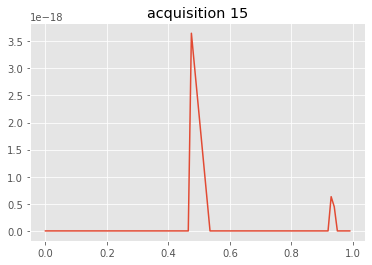

In [16]:
x_eval = torch.linspace(0,1,100).unsqueeze(-1) # evaluation input for GP

x_train = x_init # set of training data for gp
y_train = y_init

jit=1e-5 # noise term (increase if unstable)
# build likelihood (this is unchanged since not optimised during GP fit)
lik = gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.),
                                                       num_tasks=2)
lik.noise_covar.noise = jit*torch.ones(2) # set noise terms
lik.noise = torch.tensor(jit).sqrt()

for i in range(20): # Search 20 times for new points
    model = ExactGPModelWithGrad(x_train, y_train, lik) # initialise GP
    optimise(model, method='adam', max_iter=1000)       # fit GP
    u = acq(y_train[:,0].min(), model, x_eval)          # acquisition
    idx = u.argmax()                                    # index of next loc
    xn = x_eval[idx]                                    # next x
    if i % 5 == 0: # plot results every 5th step
        with torch.no_grad():
            plt.figure()
            plot_gp(model)
            plt.title('gp itr%d' % i)
            plt.figure()
            plt.plot(x_eval,u.detach())
            plt.title('acquisition %d' % i)
    # remove new point from evaluation set (avoid repeat points)
    x_eval = torch.cat([x_eval[0:idx,:],x_eval[idx+1:,:]],0)
    # add xn to training input
    x_train = torch.stack([*x_train, xn])
    # add f(xn) and df/dx|x=xn to training output
    y_train = torch.cat([y_train, torch.stack([f(xn),df(xn)],-1).squeeze(1)],0)

This is just a plot of the final gp compared to the true function

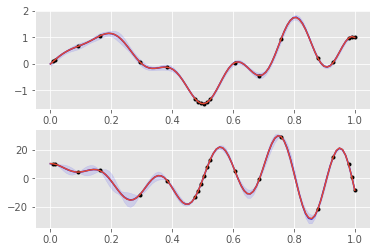

In [17]:
x_eval = torch.linspace(0,1,100).unsqueeze(-1)
plot_gp(model)
fns = [f, df]
for i, ax in enumerate(plt.gcf().axes):
    ax.plot(x_eval, fns[i](x_eval))

Comparison of identified minima vs true minima (at `x_eval` resolution)

In [18]:
print('true min: ' + str(x_eval[f(x_eval).argmin()].numpy()))
print('bayesopt min: ' + str(x_train[y_train[:,0].argmin()].numpy()))

true min: [0.5050505]
bayesopt min: [0.5050505]


evaluation of $f$ by iteration

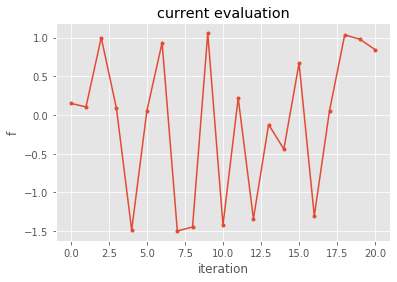

In [19]:
plt.plot(y_train[:,0],'.-')
plt.title('current evaluation')
plt.xlabel('iteration')
plt.ylabel('f');

Convergence of $f^\ast$ by iteration

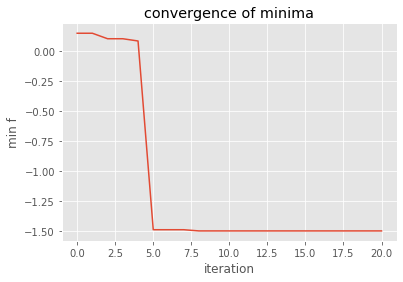

In [20]:
plt.plot([y_train[0,0],*[y_train[0:i,0].min() for i in range(1, y_train.shape[0])]])
plt.title('convergence of minima')
plt.xlabel('iteration')
plt.ylabel('min f');

In [29]:
torch.cat(2*[torch.stack([torch.tensor(0.), *torch.ones(3)]).unsqueeze(1)],1)

tensor([[0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [31]:
x_train.shape

torch.Size([21, 1])

In [49]:
X = torch.tensor([[6.9854e-06, 7.3789e-06],
        [1.2108e-04, 1.1808e-04],
        [6.9923e-01, 7.1920e-01]]).transpose(1,0)
y = torch.tensor([[ 9.9630e+01,  8.8265e+07, -2.3098e+06, -2.3810e+02],
        [ 1.4863e+02,  1.3988e+08, -4.1241e+06, -3.8658e+02]])

In [38]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(arg_num_dims=3)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [36]:
jit = 1e-5
lik = gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.),
                                                       num_tasks=4)
lik.noise_covar.noise = jit*torch.ones(4) # set noise terms
lik.noise = torch.tensor(jit).sqrt()                                          

In [50]:
model = ExactGPModel(X, y, lik)

In [59]:
optimise(model, max_iter=1000)

In [61]:
y

tensor([[ 9.9630e+01,  8.8265e+07, -2.3098e+06, -2.3810e+02],
        [ 1.4863e+02,  1.3988e+08, -4.1241e+06, -3.8658e+02]])

tensor([[5.1804e+00, 1.4943e+05, 1.4943e+05, 1.4943e+05],
        [5.1804e+00, 1.4943e+05, 1.4943e+05, 1.4943e+05]],
       grad_fn=<ViewBackward>)

tensor([73.0221, 73.0221], grad_fn=<SelectBackward>)